# expression_combined

In this notebook, we use a combination of features from the `ddg_monomer` feature set (13 features), the RosettaDesign data set (47 features), and the FoldX data set (12 features) to predict soluble expression (0=no, 1=yes) for 128 samples. Four classifiers are tried: naive Bayes, logistic regression, SVM, and random forest 

In [62]:
%matplotlib inline 
import pandas 
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt 
from sklearn import preprocessing, cross_validation, ensemble, pipeline, svm, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectKBest

In [63]:
df1 = pandas.read_csv( '../rosetta_runs/reckless_ddg_monomer/ddg_feature_set.csv', index_col=0 ) 
df2 = pandas.read_csv( 'feature_sets/expression.csv', index_col=0 ) 
df3 = pandas.read_csv( 'feature_sets/expression_foldx.csv', index_col=0 ) 

feature_set =  df1.join( df2, rsuffix='_enzyme_design' ).join( df3, rsuffix='_foldx' )
feature_set.drop( [ 'expression', 'expression_foldx' ], axis=1, inplace=True ) 
print feature_set.columns

experimental = pandas.read_csv( '../data_sets/experimental/thermo_paper_data_set.csv', index_col=0 ) 
express = experimental[ [ 'expression' ] ]

df = express.join( feature_set ).dropna()
print df.sample( 5 )

Index([u'total', u'fa_atr', u'fa_rep', u'fa_sol', u'fa_intra_rep', u'fa_elec',
       u'pro_close', u'hbond_bb_sc', u'hbond_sc', u'rama', u'omega', u'fa_dun',
       u'p_aa_pp', u'yhh_planarity', u'total_score', u'fa_rep_enzyme_design',
       u'hbond_sc_enzyme_design', u'tot_pstat_pm', u'tot_nlpstat_pm',
       u'tot_burunsat_pm', u'tot_hbond_pm', u'tot_NLconts_pm',
       u'tot_nlsurfaceE_pm', u'tot_total_charge', u'tot_total_pos_charges',
       u'tot_total_neg_charges', u'SR_1_total_score', u'SR_1_fa_rep',
       u'SR_1_hbond_sc', u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_hbond_pm', u'SR_2_burunsat_pm',
       u'SR_2_pstat_pm', u'SR_2_nlpstat_pm', u'SR_3_total_score',
       u'SR_3_fa_rep', u'SR_3_hbond_sc', u'SR_3_hbond_pm', u'SR_3_burunsat_pm',
       u'SR_3_pstat_pm', u'SR_3_nlpstat_pm', u'SR_4_total_score',
       u'SR_4_fa_rep', u'SR_4_hbond_sc', u'SR_4_hbond_pm', u'S

In [64]:
# # %matplotlib inline 
# # import matplotlib.pyplot as plt 

# plt.figure( figsize=( 14, 14 ) ) 

# for i, feature in enumerate( df.columns ):
#     plt.subplot( 4, 4, i + 1 ) 
#     plt.scatter( df.expression, df[ feature ], c='k', alpha=0.1 ) #, c=df.expression, cmap='Blues', vmin=-0.5 ) 
#     plt.title( feature ) 
#     plt.xticks( [ 0, 1 ], [ 0, 1 ] ) 

# plt.show()

**`ddg_monomer` app feature set**: individual feature versus expression (yes/no)

In [65]:
#scatter_matrix(df, alpha=0.2, figsize=(14, 14) ) #, diagonal='kde')

In [66]:
# sequence-based view of features 
#df.plot(subplots=True, style='.', figsize=(14,14))

In [67]:
# scale features and separate into predictors

scl = preprocessing.MinMaxScaler()
X = scl.fit_transform( df.ix[:,1:] )
y = df.ix[:,0:1].as_matrix().ravel()

print X.shape
print y.shape

(126, 76)
(126,)


In [68]:
# unbalanced classes 
my_list = list( y ) 
print my_list.count( 0 ), 'samples of class 0'
print my_list.count( 1 ), 'samples of class 1'

43 samples of class 0
83 samples of class 1


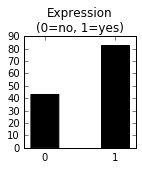

In [69]:
plt.figure( figsize=( 2,2 ) ) 
plt.hist( y, bins=2, color='k', rwidth=0.4 )
plt.xticks( [ .25, .75 ], [ '0', '1' ] ) 
plt.title( 'Expression\n(0=no, 1=yes)' ) 

In [70]:
y

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [71]:
# Split the dataset in two equal parts to be used to train and test 3 classifiers below 
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

### Begin the classifiers

             precision    recall  f1-score   support

          0       0.82      0.58      0.68        24
          1       0.78      0.92      0.85        39

avg / total       0.80      0.79      0.78        63



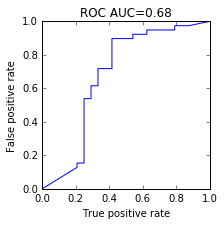

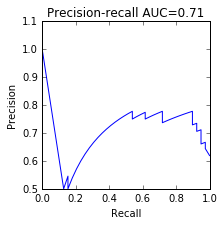

In [72]:
# random forest

from sklearn.naive_bayes import GaussianNB

param_grid = [
    { 
#         'rf__criterion': [ 'entropy', 'gini' ], 
#         'rf__n_estimators': [ 10, 50 ], 
#         'rf__max_features': [ 1, 2, 'sqrt', None ], 
#         'rf__max_depth': [ 2, 3, 6 ], 
#         'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'nb', GaussianNB() ),
])

# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

print classification_report( y_true, y_pred )

y_desc = clf.predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label
#y_prob = clf.decision_function( X_test ) 

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
# feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
# w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
# w.set_index( 'feature', inplace=True ) 
# w.sort_values( by='importance', ascending=False )

In [73]:
# random forest

param_grid = [
    { 
        'rf__criterion': [ 'entropy', 'gini' ], 
        'rf__n_estimators': [ 10, 50 ], 
        'rf__max_features': [ 1, 2, 'sqrt', None ], 
        'rf__max_depth': [ 2, 3, 6 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', ensemble.RandomForestClassifier() ),
])

             precision    recall  f1-score   support

          0       0.73      0.33      0.46        24
          1       0.69      0.92      0.79        39

avg / total       0.71      0.70      0.66        63



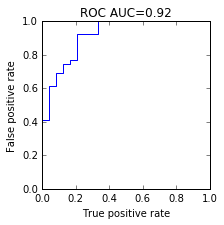

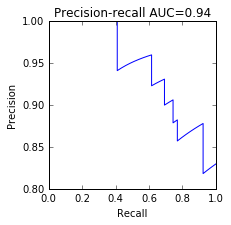

,importance
feature,
total,0.161206
total energy,0.104076
yhh_planarity,0.098179
p_aa_pp,0.049578
tot_nlpstat_pm,0.037601
Electrostatics,0.036277
fa_rep,0.030451
tot_burunsat_pm,0.029865
SR_4_hbond_sc,0.024674


In [75]:
# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

print classification_report( y_true, y_pred )

y_desc = clf.best_estimator_.named_steps['rf'].predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
w = pandas.DataFrame( zip( df.columns[1:], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

# Tuning hyper-parameters for precision


/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [10] are constant.
  UserWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [10 74] are constant.
  UserWarning)


Best parameters set found on development set:
{'kbest__k': 5, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}

Grid scores on development set:

0.503 (+/-0.531) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.001}
0.414 (+/-0.513) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}
0.353 (+/-0.526) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.0001}
0.414 (+/-0.513) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.0001}
0.251 (+/-0.372) for {'kbest__k': 2, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.001}
0.572 (+/-0.478) for {'kbest__k': 2, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}
0.251 (+/-0.372) for {'kbest__k': 2, 

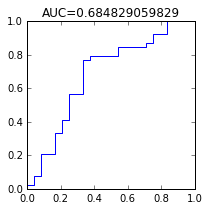

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'kbest__k': 5, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}

Grid scores on development set:

0.587 (+/-0.381) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.001}
0.524 (+/-0.368) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}
0.492 (+/-0.392) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.0001}
0.524 (+/-0.368) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.0001}
0.460 (+/-0.401) for {'kbest__k': 2, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.001}
0.635 (+/-0.349) for {'kbest__k': 2, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}


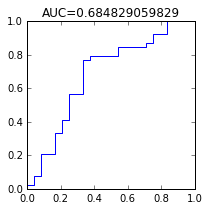

In [77]:
# SVM with KBest 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'kbest__k': [ 2, 5, 10, 20, 40 ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'kbest', SelectKBest() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

# Tuning hyper-parameters for precision


/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:
{'svm__C': 30, 'pca__n_components': 10, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}

Grid scores on development set:

0.173 (+/-0.519) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.643 (+/-0.557) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
0.236 (+/-0.592) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.643 (+/-0.557) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.189 (+/-0.442) for {'svm__C': 0.3, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm

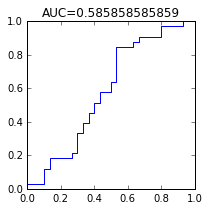

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'svm__C': 30, 'pca__n_components': 5, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}

Grid scores on development set:

0.333 (+/-0.508) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.476 (+/-0.385) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
0.397 (+/-0.573) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.476 (+/-0.385) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.349 (+/-0.502) for {'svm__C': 0.3, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten

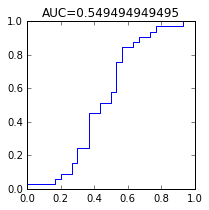

In [48]:
# SVM with PCA 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .1, .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
        'pca__whiten': [ True ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'pca', decomposition.PCA() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

Best parameters found on training set
{'logit__class_weight': 'balanced'}
Grid scores on training set
0.698 (±0.152) for {'logit__class_weight': 'balanced'}
Detailed classification report
             precision    recall  f1-score   support

          0       0.65      0.43      0.52        30
          1       0.60      0.79      0.68        33

avg / total       0.63      0.62      0.61        63



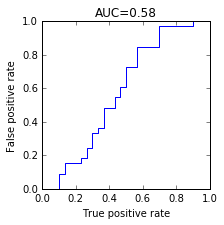

MCC= 0.237343472398


In [49]:
# logistic regression 

# Set the parameters by cross-validation
param_grid = [
    { 
        'logit__class_weight': [ 'balanced' ],
    },
]
  
pln = pipeline.Pipeline([
    ( 'logit', LogisticRegressionCV() ),
])

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

#y_desc = clf.predict_proba( X_test )
# gives a pair p(0), p(1) where p is probability and [0,1] are class labels 
# sum to 1 
#y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label
y_prob = clf.decision_function( X_test ) 

tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

print 'MCC=', matthews_corrcoef( y_true, y_pred ) 